In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import quote_plus
from sqlalchemy import create_engine
import json
import numpy as np

db_config = open('../../config/database.json')
db_config = json.load(db_config)

# PostgreSQL database connection URL (update with your actual database URL)

# Create a SQLAlchemy engine to connect to the database
engine = create_engine("postgresql://postgres:%s@localhost:5432/finance" % quote_plus(db_config["pg_password"]))

# SQL query to fetch data from the database (replace with your query)
sql_query = "SELECT * FROM us_data"

# Execute the query and load the results into a pandas DataFrame
raw_data = pd.read_sql_query(sql_query, engine)

# Close the database connection when done
engine.dispose()

# Print the first few rows of the DataFrame
print(raw_data.shape)
raw_data.dtypes

(239830, 11)


complaint_id                    float64
date_received                    object
date_sent_to_company             object
product                          object
consumer_complaint_narrative     object
submittedvia                     object
timelyresponse                   object
issue                            object
subissue                         object
company                          object
state                            object
dtype: object

In [29]:
import json
ml_pipeline_config = open('../../config/ml_pipeline.json')
ml_pipeline_config = json.load(ml_pipeline_config)

In [30]:
raw_data.head()

,complaint_id,date_received,date_sent_to_company,product,consumer_complaint_narrative,submittedvia,timelyresponse,issue,subissue,company,state
0,7188019.0,06/30/23,06/30/23,Credit card or prepaid card,I signed up for a Citi Bank card and and have ...,Web,Yes,Struggling to pay your bill,Credit card company won't work with you while ...,"CITIBANK, N.A.",NC
1,7188842.0,06/30/23,06/30/23,Debt collection,On XX/XX/2023 at XXXXXXXX XXXX I received a bi...,Web,Yes,False statements or representation,Attempted to collect wrong amount,Global Lending Services LLC,CO
2,7189350.0,06/30/23,06/30/23,Debt collection,"Good morning -- I bought the equipment, but th...",Web,Yes,Attempts to collect debt not owed,Debt is not yours,TRANSWORLD SYSTEMS INC,TX
3,7191472.0,07-01-2023,07-01-2023,"Credit reporting, credit repair services, or o...",NOTICE TO SUPPRESS LISTED ACCOUNTS The FCRA st...,Web,Yes,Incorrect information on your report,Account information incorrect,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX
4,7106838.0,06-12-2023,06-12-2023,Credit card or prepaid card,I urge you to expedite the update of my accoun...,Web,Yes,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,Experian Information Solutions Inc.,NC


In [31]:
raw_data.shape

(239830, 11)

In [32]:
raw_data.isnull().sum()

complaint_id                        3
date_received                       0
date_sent_to_company                0
product                             0
consumer_complaint_narrative        0
submittedvia                        0
timelyresponse                      3
issue                               0
subissue                        10988
company                             0
state                             571
dtype: int64

In [33]:
raw_data.groupby('product').consumer_complaint_narrative.count()

product
Checking or savings account                                                      13213
Credit card                                                                       6385
Credit card or prepaid card                                                      11567
Credit reporting or other personal consumer reports                              56424
Credit reporting, credit repair services, or other personal consumer reports    117221
Debt collection                                                                  16605
Debt or credit management                                                          139
Money transfer, virtual currency, or money service                                3892
Mortgage                                                                          5787
Payday loan, title loan, or personal loan                                         1450
Payday loan, title loan, personal loan, or advance loan                            659
Prepaid card                       

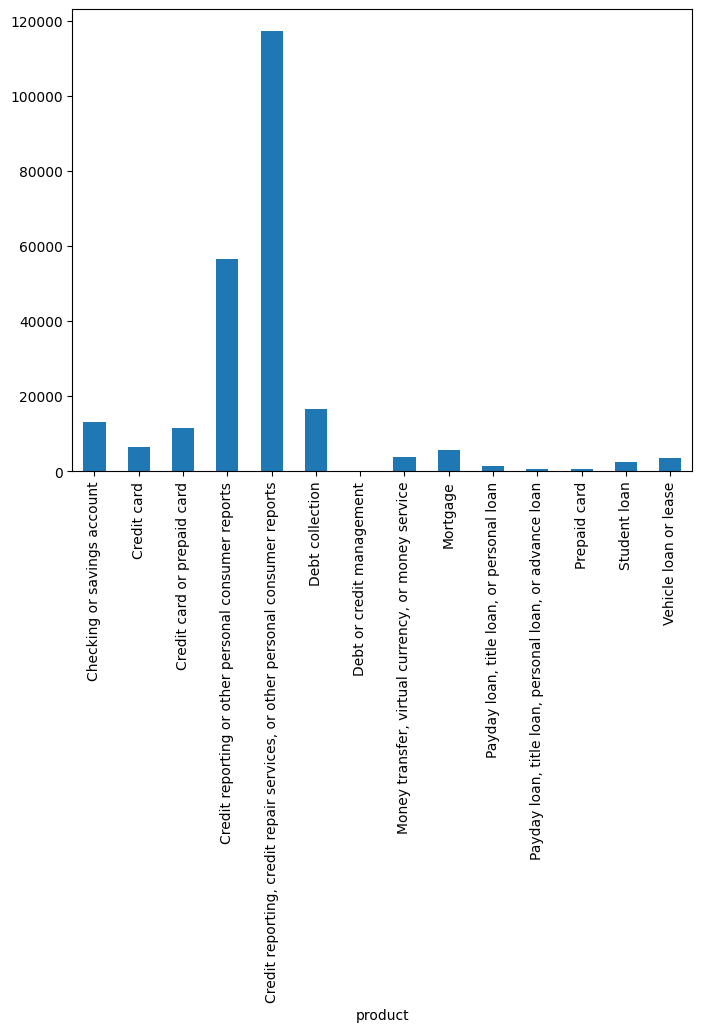

In [34]:
fig = plt.figure(figsize=(8,6))
raw_data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [35]:
raw_data["product"].unique()

array(['Credit card or prepaid card', 'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit reporting or other personal consumer reports',
       'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Credit card', 'Student loan',
       'Payday loan, title loan, or personal loan',
       'Vehicle loan or lease',
       'Payday loan, title loan, personal loan, or advance loan',
       'Prepaid card', 'Mortgage', 'Debt or credit management'],
      dtype=object)

In [36]:
raw_data["product"].replace("Credit reporting or other personal consumer reports","Credit reporting, credit repair services, or other personal consumer reports",inplace=True)
raw_data["product"].replace("Credit card","Credit card or prepaid card",inplace=True)
raw_data["product"].replace("Payday loan, title loan, or personal loan","Payday loan, title loan, personal loan, or advance loan",inplace=True)
raw_data["product"].replace("Prepaid card","Credit card or prepaid card",inplace=True)

In [37]:
temp = raw_data["product"].value_counts().to_dict()
min_key = min(temp, key=lambda k: temp[k])
print(min_key)

Debt or credit management


In [38]:
temp

{'Credit reporting, credit repair services, or other personal consumer reports': 173645,
 'Credit card or prepaid card': 18489,
 'Debt collection': 16605,
 'Checking or savings account': 13213,
 'Mortgage': 5787,
 'Money transfer, virtual currency, or money service': 3892,
 'Vehicle loan or lease': 3494,
 'Student loan': 2457,
 'Payday loan, title loan, personal loan, or advance loan': 2109,
 'Debt or credit management': 139}

In [39]:
while True:
    if temp[min_key]<1500:
        raw_data = raw_data[raw_data['product'] != "Debt or credit management"]
        temp = raw_data["product"].value_counts().to_dict()
        min_key = min(temp, key=lambda k: temp[k])
        print(min_key)
    else:
        print(min_key,temp[min_key])
        break

Payday loan, title loan, personal loan, or advance loan
Payday loan, title loan, personal loan, or advance loan 2109


In [40]:
temp_data = pd.DataFrame()
for category in raw_data["product"].unique():
    filtered_df = raw_data[raw_data['product'] == category]
    if len(filtered_df) >= 10:
        # Randomly select 10 rows
        random_rows = filtered_df.sample(n=np.random.randint(temp[min_key]-300,temp[min_key])  , random_state=42)
        temp_data = pd.concat([temp_data, random_rows], ignore_index=True)
        print(category)
    else:
        print(f"There are fewer than 10 rows with '{target_text}' in 'Column1'.")

Credit card or prepaid card
Debt collection
Credit reporting, credit repair services, or other personal consumer reports
Checking or savings account
Money transfer, virtual currency, or money service
Student loan
Payday loan, title loan, personal loan, or advance loan
Vehicle loan or lease
Mortgage


In [41]:
temp_data.shape

(17481, 11)

In [42]:
raw_data = temp_data

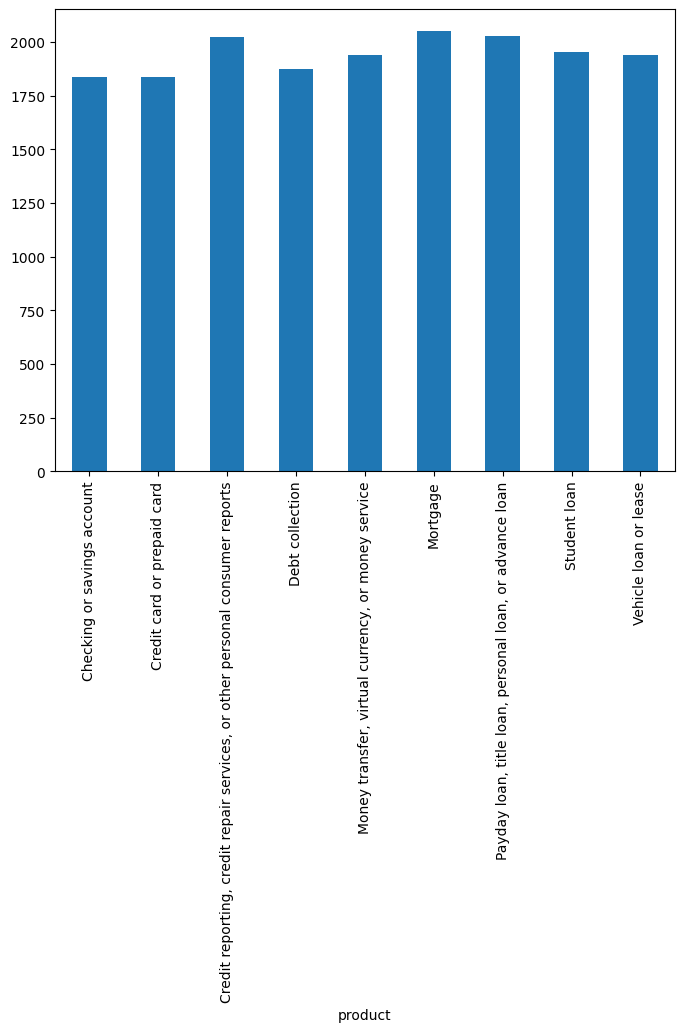

In [43]:
fig = plt.figure(figsize=(8,6))
raw_data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [44]:
# data = raw_data[['product','consumer_complaint_narrative']]
raw_data = raw_data.replace('',None)
# data = data[data['consumer_complaint_narrative'].notnull()]
raw_data.to_csv(ml_pipeline_config["processed_data_path"],index=False)